# Proyección de ventas en unidades
## Gerardo Alvarado A.
### El objetivo del proyecto es la proyección de las ventas en unidades de cada uno de los productos en un mes seleccionado.

### Se realizará una exploración de los datos para identificar tendencias, estacionalidades, meses de mayor venta, relación entre las diferentes variables proporcionadas, para así, poder realizar la recomendación de acuerdo al objetivo del proyecto. 


In [257]:
#Importación de las librerías requeridas

#numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from statsmodels.tsa.arima_model import ARIMA
import dateutil.parser
from matplotlib import cbook, dates
from matplotlib.ticker import Formatter
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot


#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

#cross validation
from sklearn.model_selection import train_test_split

### Carga de los datos

#### La información del set de datos corresponde a las ventas de la categoría de Atún en Centroamérica

#### El set de datos contiene la información de ventas de los productos a analizar del 2019 de manera mensual en tres tipos de 
#### variables: unidades, valor y precios

#### Adicionalmente contiene información referente a las características de cada producto y los lugares en los que se vendió cada uno de ellos


In [258]:
#Cargar el archivo de ventas

rawData = pd.read_csv('Ventas Productos Mensuales.csv', header=0)

In [259]:
# Validación de la estructura de los datos

rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 44 columns):
CodPais      465 non-null int64
CodCad       465 non-null int64
CodProd      465 non-null int64
CodMar       465 non-null object
UE           465 non-null int64
Contenido    465 non-null int64
CodSub       465 non-null object
CodSeg       465 non-null object
V201901      465 non-null float64
V201902      465 non-null float64
V201903      465 non-null float64
V201904      465 non-null float64
V201905      465 non-null float64
V201906      465 non-null float64
V201907      465 non-null float64
V201908      465 non-null float64
V201909      465 non-null float64
V201910      465 non-null float64
V201911      465 non-null float64
V201912      465 non-null float64
P201901      465 non-null float64
P201902      465 non-null float64
P201903      465 non-null float64
P201904      465 non-null float64
P201905      465 non-null float64
P201906      465 non-null float64
P201907      465 non-nul

### Visualización de los valores de los datos para identificar las características

In [260]:
# Visualización de los datos acumulados

rawData.head()

,CodPais,CodCad,CodProd,CodMar,UE,Contenido,CodSub,CodSeg,V201901,V201902,...,U201903,U201904,U201905,U201906,U201907,U201908,U201909,U201910,U201911,U201912
0,1,2,223,G,48,140,V,S,116585720.0,162345360.0,...,340172,292219,296435,309352,344646,370523,362436,350898,326085,358173
1,1,2,39,F,24,420,T,S,71181750.0,68087500.0,...,24488,21167,11333,12682,30114,27501,30183,17129,8888,6582
2,1,2,139,G,12,560,T,S,25470.0,25474935.0,...,42318,57956,37233,38965,42224,52175,43608,3725,331,7
3,1,1,39,F,24,420,T,S,16254000.0,40261000.0,...,24621,29992,22831,19461,27298,23428,19920,10077,3747,4991
4,1,2,140,G,8,140,T,S,2550.0,6471950.0,...,13767,25899,21681,20971,17451,18004,21023,26961,6111,41


## Exploración de los datos

### Revisión de los contenidos de las variables y los niveles de concentración de información en cada variable con el objetivo de identificar patrones y entender la información, para posteriormente desarrollar el modelo que más se ajusta a las caracteríscas de la información y el objetivo del proyecto

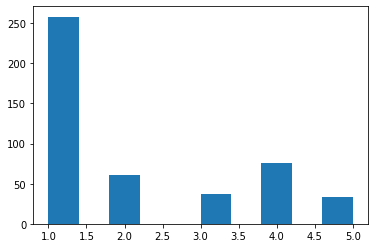

In [261]:
# Revisión de la variable CodPais - Hace referencia al país
plt.hist(rawData['CodPais'])
plt.show()

#### En los datos se puede identificar que el país que presenta la mayor cantidad de ventas es el país con código = 1, mientras que los restantes países no tienen una representatividad alto

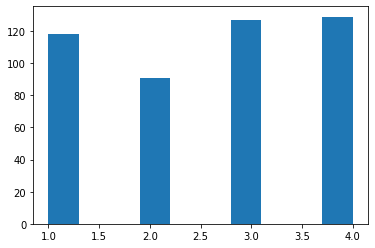

In [262]:
# Revisión de la variable CodCad - Hace referencia al tipo de tienda donde se vendió el producto
plt.hist(rawData['CodCad'])
plt.show()

#### En cuanto a las ventas por cadena, la distribución de las ventas muestra que los formatos con código = 2 son los que tienen una menor representatividad en las ventas 

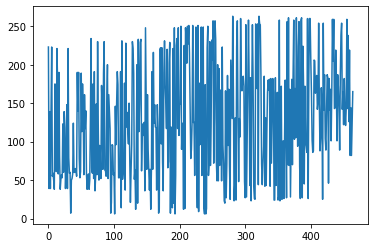

In [263]:
# Revisión de la variable CodProd - Hace referencia al producto 
plt.plot(rawData['CodProd'])
plt.show()

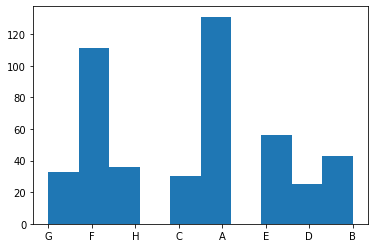

In [264]:
# Revisión de la variable CodMar - Hace referencia a la marca del producto
plt.hist(rawData['CodMar'])
plt.show()

#### En la revisión de las ventas por marcas, podemos identificar la mayor representación de dos marcas con influencia en las ventas.

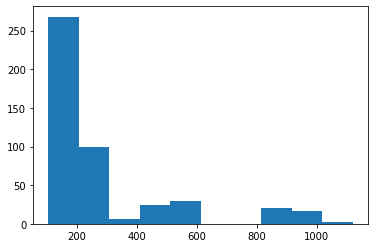

In [265]:
# Revisión de la variable Contenido - Hace referencia al contenido de los productos
plt.hist(rawData['Contenido'])
plt.show()

#### Las ventas por contenido de producto nos indican que existe una mayor cantidad de ventas de productos de contenido bajo, menor de 200 gramos por unidad

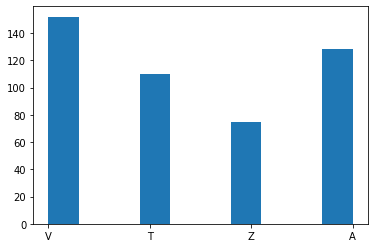

In [266]:
# Revisión de la variable CodSub - Hace referencia al tipo de categoría al que pertenece el producto
plt.hist(rawData['CodSub'])
plt.show()

#### Hay una mayor cantidad de ventas de dos categorías de productos, concentrados en los tipos de categorías con el código A y V

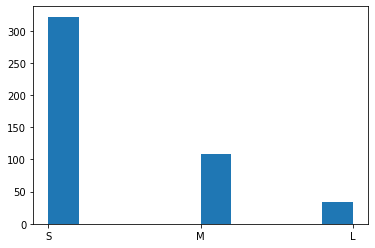

In [267]:
# Revisión de la variable CodSeg - Hace referencia al segmento de tamaño que pertenece el producto
plt.hist(rawData['CodSeg'])
plt.show()

#### En cuanto al segmento de tamaño, se refuerza el dato de que aquellos productos con menor tamaño son los que representan el mayor porcentaje de las ventas:

### Creación de variables para almacenar la suma por mes de las ventas en unidades y en valor y posteriormente  la revisión por mes de los datos

In [271]:
# Suma de las variables de Ventas en valor

VEne=rawData['V201901'].sum()
VFeb=rawData['V201902'].sum()
VMar=rawData['V201903'].sum()
VAbr=rawData['V201904'].sum()
VMay=rawData['V201905'].sum()
VJun=rawData['V201906'].sum()
VJul=rawData['V201907'].sum()
VAgo=rawData['V201908'].sum()
VSet=rawData['V201909'].sum()
VOct=rawData['V201910'].sum()
VNov=rawData['V201911'].sum()
VDic=rawData['V201912'].sum()

# Suma de las variables de Ventas en unidades
UEne=rawData['U201901'].sum()
UFeb=rawData['U201902'].sum()
UMar=rawData['U201903'].sum()
UAbr=rawData['U201904'].sum()
UMay=rawData['U201905'].sum()
UJun=rawData['U201906'].sum()
UJul=rawData['U201907'].sum()
UAgo=rawData['U201908'].sum()
USet=rawData['U201909'].sum()
UOct=rawData['U201910'].sum()
UNov=rawData['U201911'].sum()
UDic=rawData['U201912'].sum()

### Creación de un data frame con los valores de las ventas totales en valor y unidades para analizar y entender los meses de mayor venta de los productos, validar estacionalidades o temporadas en las ventas mensuales de la categoría

In [272]:
# Creación de los índices
indices=['1','2','3','4','5','6','7','8','9','10','11','12']

# Valores de la variable mes
mes=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Set','Oct','Nov','Dic']

# Asignación de los valores de la variable Unidades
Uds=[UEne,UFeb,UMar,UAbr,UMay,UJun,UJul,UAgo,USet,UOct,UNov,UDic]

# Asignación de los valores de la variable Valor
Val=[VEne,VFeb,VMar,VAbr,VMay,VJun,VJul,VAgo,VSet,VOct,VNov,VDic]

#Creación de las columnas del dataFrame
Ventas ={'Mes':mes,'Unidades':Uds,'Valor':Val}

# Creación del dataframe y asignación de los valores
DFVentas=pd.DataFrame(data=Ventas,index=indices)

#Visualización del dataframe
DFVentas

,Mes,Unidades,Valor
1,Ene,1922955,2.253868e+09
2,Feb,1840483,2.124933e+09
3,Mar,2243710,2.563068e+09
4,Abr,2166707,2.469936e+09
5,May,1872352,2.145730e+09
6,Jun,1790156,2.188798e+09
7,Jul,1891145,2.264295e+09
8,Ago,1942574,2.277188e+09
9,Set,1765520,2.117279e+09
10,Oct,1648990,1.893696e+09


### Graficación de las ventas en unidades para identificar estacionalidades o los meses de mayor venta

Text(0.5, 1.0, 'Ventas Unidades por Mes')

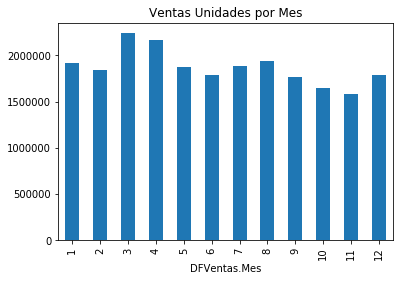

In [273]:
DFVentas.Unidades.plot(kind='bar')
plt.xlabel('DFVentas.Mes')
plt.title('Ventas Unidades por Mes')

#### En la revisión de la variable se puede identificar un comportamiento de mayor ventas en los meses de marzo y abril
#### Dado que los datos pertenecen a la categoría de Atún, este comportamiento puede estar influenciado por el comportamiento de los consumidores al mayor consumo de proteína de pescado vs las proteínas de carne de res o pollo

### Graficación de las ventas en valor para identificar las estacionalidades o si existe un comportamiento diferente en el valor de la categoría con respecto a los precios

Text(0.5, 1.0, 'Ventas Valor por Mes')

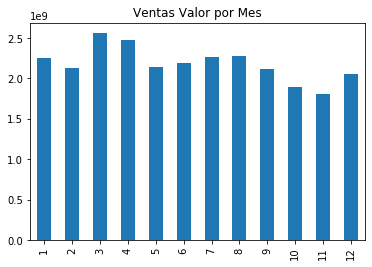

In [274]:
DFVentas.Valor.plot(kind='bar')
plt.title('Ventas Valor por Mes')

#### Al igual que los resultados identificados en las ventas en unidades, las ventas en valor muestran un comportamiento de mayor venta en los meses de marzo y abril, con una tendencia similar entre ambas variables, lo que hace indicar que el precio está bastante relacionado a ambas

### Identificados los meses de mayor venta, se van a realizar algunas revisiones de los datos en los meses de mayor venta, los cuales son marzo y abril

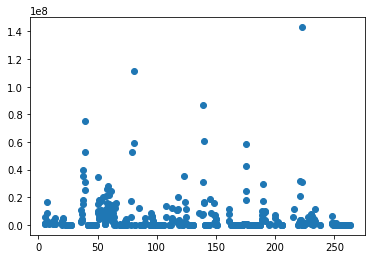

In [268]:
##Exploración de los productos en un periodo específico

x = rawData['CodProd']
y = rawData['V201904']


plt.scatter(x,y)
plt.show()

#### Se realiza una exploración de las ventas de los productos en el mes 04, dado que es uno de los meses de mayor representación en las ventas para entender la disperción de las ventas por producto.

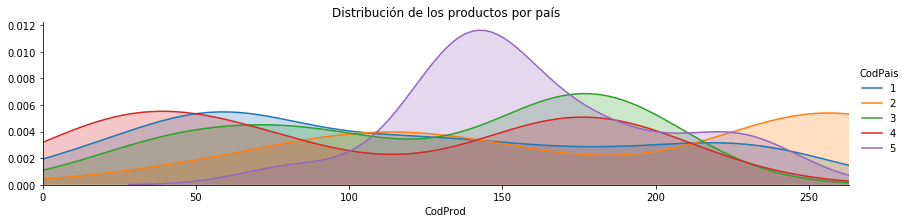

In [269]:
# Códigos por país

fig = sns.FacetGrid(rawData, hue='CodPais', aspect=4)
fig.map(sns.kdeplot, 'CodProd', shade=True)
oldest = rawData['CodProd'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribución de los productos por país')
fig.add_legend()

#### Para entender la concentración de códigos por país se realizó la revisión de esta concentración, pero no se identifica ningún comportamiento atípico en la información.

Text(0.5, 1.0, 'Ventas por Cadena')

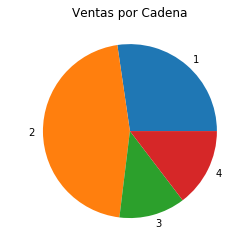

In [270]:
# Revisión de las ventas por cadena en el mes de abril

rawData.V201904.groupby(rawData.CodCad).sum().plot(kind='pie')
plt.ylabel(' ')
plt.title('Ventas por Cadena')

#### Al revisar las ventas por cadena en un mes específico, se identifica una representación alta de las tiendas del código =2

## Matriz de correlación
#### Creación de la Matriz para valorar la correlación de las variables

In [275]:
corr_matrix = rawData.corr().round(decimals=2)
corr_matrix

,CodPais,CodCad,CodProd,UE,Contenido,V201901,V201902,V201903,V201904,V201905,...,U201903,U201904,U201905,U201906,U201907,U201908,U201909,U201910,U201911,U201912
CodPais,1.00,0.04,0.04,0.33,-0.33,-0.35,-0.32,-0.32,-0.31,-0.33,...,-0.15,-0.15,-0.15,-0.15,-0.14,-0.13,-0.12,-0.12,-0.12,-0.13
CodCad,0.04,1.00,0.02,-0.02,0.03,-0.16,-0.14,-0.15,-0.15,-0.16,...,-0.12,-0.13,-0.12,-0.11,-0.09,-0.09,-0.09,-0.09,-0.09,-0.10
CodProd,0.04,0.02,1.00,-0.10,0.06,-0.16,-0.11,-0.10,-0.10,-0.11,...,-0.01,-0.02,-0.01,0.00,0.01,0.01,0.02,0.02,0.02,0.02
UE,0.33,-0.02,-0.10,1.00,-0.87,-0.04,-0.09,-0.14,-0.14,-0.11,...,0.05,0.05,0.06,0.05,0.04,0.04,0.04,0.05,0.06,0.06
Contenido,-0.33,0.03,0.06,-0.87,1.00,0.07,0.09,0.12,0.11,0.07,...,-0.05,-0.04,-0.06,-0.06,-0.05,-0.06,-0.05,-0.06,-0.06,-0.06
V201901,-0.35,-0.16,-0.16,-0.04,0.07,1.00,0.90,0.82,0.75,0.78,...,0.70,0.69,0.70,0.67,0.65,0.63,0.62,0.62,0.62,0.63
V201902,-0.32,-0.14,-0.11,-0.09,0.09,0.90,1.00,0.92,0.86,0.89,...,0.82,0.80,0.82,0.82,0.82,0.80,0.80,0.79,0.78,0.80
V201903,-0.32,-0.15,-0.10,-0.14,0.12,0.82,0.92,1.00,0.98,0.96,...,0.84,0.85,0.82,0.75,0.72,0.71,0.71,0.68,0.67,0.69
V201904,-0.31,-0.15,-0.10,-0.14,0.11,0.75,0.86,0.98,1.00,0.96,...,0.78,0.83,0.77,0.68,0.65,0.63,0.63,0.60,0.58,0.60
V201905,-0.33,-0.16,-0.11,-0.11,0.07,0.78,0.89,0.96,0.96,1.00,...,0.83,0.85,0.84,0.80,0.76,0.75,0.75,0.72,0.71,0.72


### Graficación de la matriz de Correlación

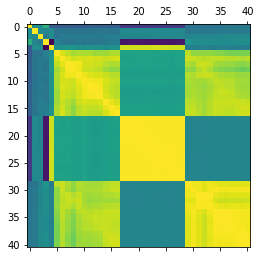

In [276]:
plt.matshow(rawData.corr().round(decimals=2))
plt.show()

### Selección de las características a utilizar
#### Se seleccionaron las variables de unidades, valor y precio para el desarrollo de los modelos dada la información que nos muestra la matriz de correlació. Permite identificar una correlación importante entre estas variables seleccionadas.

In [277]:
#features
features = rawData.iloc[:,8:43]
print('Summary of feature sample')
features.head()

Summary of feature sample


,V201901,V201902,V201903,V201904,V201905,V201906,V201907,V201908,V201909,V201910,...,U201902,U201903,U201904,U201905,U201906,U201907,U201908,U201909,U201910,U201911
0,116585720.0,162345360.0,166611874.0,143077834.0,144982455.0,151564198.0,170543266.0,185115676.0,177636070.0,170163765.0,...,331320,340172,292219,296435,309352,344646,370523,362436,350898,326085
1,71181750.0,68087500.0,61219850.0,52914650.0,28369302.0,32965993.0,75427924.0,69052389.0,78372043.0,38109711.0,...,27235,24488,21167,11333,12682,30114,27501,30183,17129,8888
2,25470.0,25474935.0,63477000.0,86933130.0,60403377.0,68759178.0,77635256.0,101126564.0,84502227.0,7217216.0,...,16694,42318,57956,37233,38965,42224,52175,43608,3725,331
3,16254000.0,40261000.0,61551299.0,74957900.0,57141776.0,50502806.0,67675034.0,58534567.0,49667684.0,21397810.0,...,16105,24621,29992,22831,19461,27298,23428,19920,10077,3747
4,2550.0,6471950.0,37196075.0,60845968.0,60572160.0,59459428.0,50292454.0,52174686.0,60891798.0,78080287.0,...,2539,13767,25899,21681,20971,17451,18004,21023,26961,6111


### Selección de la variable dependiente
#### Se define la variable "U201904" como el mes a proyectar las ventas del producto dado que es uno de los meses de mayor venta para la categoría, al mismo tiempo, el objetivo del proyecto es poder realizar las proyecciones para el mes que se requiera dada la necesidad del negocio 
#### Una vez desarrollado el modelo, se puede realizar el cambio de la variable dependiente de manera tal, que se realice la proyección de las unidades a vender del mes seleccionado


In [278]:
#dependent variable
depVar = rawData['U201904']

### Establecimiento del set de entrenamiento Variables X

In [279]:
#Training Set (Feature Space: X Training)
X_train = (features[:140])
X_train.head()

,V201901,V201902,V201903,V201904,V201905,V201906,V201907,V201908,V201909,V201910,...,U201902,U201903,U201904,U201905,U201906,U201907,U201908,U201909,U201910,U201911
0,116585720.0,162345360.0,166611874.0,143077834.0,144982455.0,151564198.0,170543266.0,185115676.0,177636070.0,170163765.0,...,331320,340172,292219,296435,309352,344646,370523,362436,350898,326085
1,71181750.0,68087500.0,61219850.0,52914650.0,28369302.0,32965993.0,75427924.0,69052389.0,78372043.0,38109711.0,...,27235,24488,21167,11333,12682,30114,27501,30183,17129,8888
2,25470.0,25474935.0,63477000.0,86933130.0,60403377.0,68759178.0,77635256.0,101126564.0,84502227.0,7217216.0,...,16694,42318,57956,37233,38965,42224,52175,43608,3725,331
3,16254000.0,40261000.0,61551299.0,74957900.0,57141776.0,50502806.0,67675034.0,58534567.0,49667684.0,21397810.0,...,16105,24621,29992,22831,19461,27298,23428,19920,10077,3747
4,2550.0,6471950.0,37196075.0,60845968.0,60572160.0,59459428.0,50292454.0,52174686.0,60891798.0,78080287.0,...,2539,13767,25899,21681,20971,17451,18004,21023,26961,6111


### Establecimiento del Set Training para la variable Y dependiente

In [280]:
#Dependent Variable Training Set (y Training)
y_train = depVar[:140]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 140


0    292219
1     21167
2     57956
3     29992
4     25899
Name: U201904, dtype: int64

### Establecimiento del set Test para la variable X

In [281]:
#Testing Set (X Testing)
X_test = features[-325:]
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
print(X_test.head())

The number of observations in the feature testing set is: 325
       V201901    V201902    V201903    V201904    V201905    V201906  \
140    68950.0  1740265.0  4428260.0  3785620.0  4871200.0  5129593.0   
141  3849400.0  5099600.0  7182500.0  4544640.0  2388599.0  3396879.0   
142  9476750.0  6504500.0  6672755.0  6098825.0  3810030.0  2804800.0   
143  2151198.0  1387600.0  3073004.0  4305675.0  3851354.0  2304624.0   
144  2744150.0  1282450.0  1520425.0  1974000.0  3951800.0  2214090.0   

       V201907    V201908    V201909    V201910  ...  U201902  U201903  \
140  3278481.0  3360427.0  3318825.0  3253609.0  ...      315      736   
141  1770099.0   750190.0   645966.0  4876489.0  ...     1159     1633   
142  1793183.0  1233301.0   764668.0   476658.0  ...     6578     6875   
143  3014326.0  4402528.0  3717372.0  3280531.0  ...     2501     4752   
144  1446454.0  3384463.0  3482987.0  5384405.0  ...      724     1276   

     U201904  U201905  U201906  U201907  U201908  U201

### Establecimiento del Ground truth

In [282]:
#Ground Truth (y_test)
y_test = depVar[-325:]
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 325


140     635
141    1031
142    6251
143    5494
144    1974
Name: U201904, dtype: int64

## Cross Validation

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
X_train.shape, X_test.shape

((105, 35), (35, 35))

## Desarrollo de los modelos

### Se utilizaron tres tipos de algoritmos para el desarrollo de los modelos, los cuales por la naturaleza de la predicción, a realizar son los más robustos para los ejercicios de regresión, mismo que nos permite resolver el problema que buscamos resolver

In [284]:
#models
modelSVR = SVR()
modelRF = RandomForestRegressor()
modelLR = LinearRegression()

In [285]:
#dependent variable
print(depVar)

0      292219
1       21167
2       57956
3       29992
4       25899
        ...  
460       838
461       516
462       747
463       716
464       805
Name: U201904, Length: 465, dtype: int64


In [286]:
#Random Forest
modelRF.fit(X_train,y_train)

#Support Vector Regresion
modelSVR.fit(X_train,y_train)

#Linear Regression
modelLR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Seleccionando el modelo más adecuado

### Random Forest Regression - Ajuste del modelo y evaluación

In [287]:
print(cross_val_score(modelRF, X_train, y_train))
modelRF.score(X_train,y_train)

[0.17047361 0.57663162 0.39840626]


0.8863769966339975

### Support Vector Regression - Ajuste del modelo y evaluación

In [288]:
print(cross_val_score(modelSVR, X_train, y_train)) 
modelSVR.score(X_train,y_train)

[-0.07769218 -0.02245448 -0.10286419]


-0.04269783335781674

### Linear Regression - Ajuste del modelo y evaluación

In [289]:
print(cross_val_score(modelLR, X_train, y_train)) 
modelLR.score(X_train,y_train)

[1. 1. 1.]


1.0

## Predicciones

### Desarrollo del modelo utilizando el Random Forest dado que es el modelo que presenta los mejores resultados

In [291]:
#Make Predictions
predictions = modelRF.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.516
RMSE: 18764.460


## Graficación de los resultados

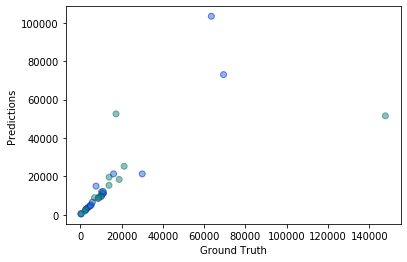

In [292]:
plt.scatter(y_test, predictions, edgecolor=['blue','green'], alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

In [293]:
predictions

array([  3136.8,   3091.3,  10966.7,  11951.3,  11380.4,   5321.7,
          593.7,  11014.8,   2043. ,  25307. ,   9553.6,  52556.3,
        21325.1,  15398.8,   9223.2,  10045.3,  73014.9,   8964.7,
       103391.9,  19621.2,    503. ,   2766.1,  21354.9,   8621.3,
         3851. ,    508.2,   4488.3,  51556.5,   4880.8,  18442.6,
         6612.4,   8593.4,  14977.8,   2527.5,  12248. ])